In [1]:
from google.cloud.aiplatform.prediction import LocalModel 
from src.custom_sam_predictor import CustomSamPredictor 
import os
import logging

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
USER_SRC_DIR = "src"
REGION = "us-west1"
REPOSITORY = "sam-container"  # @param {type:"string"}
PROJECT_ID = "ml-ops-segment-anything"
IMAGE = "sam-cpr-container"  # @param {type:"string"}
LOCAL_MODEL_ARTIFACTS_DIR = "model_artifacts"

In [5]:
# Remove all unused containers
#!docker system prune -f

In [15]:
#!docker <container/image/builder> prune --all
#!docker system df

In [6]:
local_model = LocalModel.build_cpr_model(
    USER_SRC_DIR,
    f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPOSITORY}/{IMAGE}",
    predictor=CustomSamPredictor,
    requirements_path=os.path.join(USER_SRC_DIR, "requirements.txt"),
    base_image= "pytorch/pytorch:1.13.1-cuda11.6-cudnn8-runtime"
)

INFO:google.cloud.aiplatform.docker_utils.build:Running command: docker build -t us-west1-docker.pkg.dev/ml-ops-segment-anything/sam-container/sam-cpr-container --rm -f- src
/opt/conda/lib/python3.10/subprocess.py:955: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:961: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
INFO:google.cloud.aiplatform.docker_utils.local_util:Sending build context to Docker daemon  375.1MB
INFO:google.cloud.aiplatform.docker_utils.local_util:

INFO:google.cloud.aiplatform.docker_utils.local_util:Step 1/14 : FROM pytorch/pytorch:1.13.1-cuda11.6-cudnn8-runtime

INFO:google.cloud.aiplatform.docker_utils.local_util: ---> 71eb2d092138

INFO:google.cloud.aiplatform.docker_utils.local_util:Step 2/14 : 

In [7]:
local_model.get_serving_container_spec()

image_uri: "us-west1-docker.pkg.dev/ml-ops-segment-anything/sam-container/sam-cpr-container"
predict_route: "/predict"
health_route: "/health"

In [27]:
INPUT_FILE_WITH_PROMPTS = "/home/jupyter/ml-ops-segment-anything/vertexAI_online_predictions/input_with_prompts.jsonl"
INPUT_FILE_WITHOUT_PROMPTS = "/home/jupyter/ml-ops-segment-anything/vertexAI_online_predictions/input_without_prompts.jsonl"

### Deploying Locally

In [29]:
with local_model.deploy_to_local_endpoint(
    artifact_uri=f"{LOCAL_MODEL_ARTIFACTS_DIR}",
    gpu_count=1
    
) as local_endpoint:
    print("predicting")
    predict_response = local_endpoint.predict(
        request_file=INPUT_FILE_WITH_PROMPTS,
        headers={"Content-Type": "application/json"},
    )

    health_check_response = local_endpoint.run_health_check()

INFO:google.cloud.aiplatform.prediction.local_endpoint:Got the project id from the global config: ml-ops-segment-anything.


predicting


In [30]:
# print the response
print(predict_response.json())

{'response_file': '1691462021.jsonl'}


In [8]:
# Push the container to ARTIFACTS REGISTRY
local_model.push_image()

/opt/conda/lib/python3.10/subprocess.py:955: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
/opt/conda/lib/python3.10/subprocess.py:961: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
INFO:google.cloud.aiplatform.docker_utils.local_util:Using default tag: latest

INFO:google.cloud.aiplatform.docker_utils.local_util:The push refers to repository [us-west1-docker.pkg.dev/ml-ops-segment-anything/sam-container/sam-cpr-container]

INFO:google.cloud.aiplatform.docker_utils.local_util:c9610e88a179: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:2769829f433a: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:5b9d9543dac2: Preparing

INFO:google.cloud.aiplatform.docker_utils.local_util:57b0b928d4cd: Preparing

INFO:google.cloud.aiplatform

### Testing the ENDPOINT

In [10]:
!curl \
-X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
https://us-west1-aiplatform.googleapis.com/v1/projects/633534855904/locations/us-west1/endpoints/2462281523613663232:predict \
-d "@input_without_prompts.jsonl"

{
  "error": {
    "code": 503,
    "message": "Model server connection error. Please retry. endpoint_id: 2462281523613663232, deployed_model_id: 1992534971855667200",
    "status": "UNAVAILABLE"
  }
}


In [32]:
from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.bucket("segment-anything")
# Get Model artifact from cloud storage
blob = bucket.blob('online-predict-results/1691462021.jsonl')
blob.download_to_filename('1691462021.jsonl')

In [33]:
import json

x = json.load(open('1691462021.jsonl'))

In [34]:
x.keys()

dict_keys(['file_path', 'masks', 'scores', 'logits'])

In [44]:
import numpy as np

input_point = np.array([[500, 375]])
input_label = np.array([1])

masks = np.array(x["masks"])
scores = np.array(x["scores"])
logits = np.array(x["logits"])

In [45]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    

In [46]:
import cv2
image = cv2.imread('/home/jupyter/ml-ops-segment-anything/demo-notebooks/images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

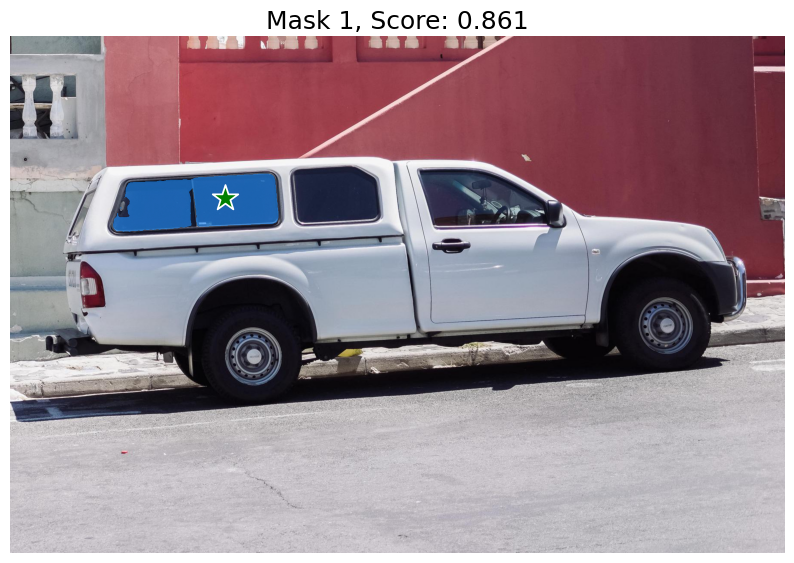

In [47]:
import matplotlib.pyplot as plt
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [11]:
!gcloud auth print-access-token

ya29.c.b0Aaekm1Kmaw3NDRFQYjPkv6TNcopXwyUHoBNMM4qS_V3qKJYtl-Qs_L0aXYF6xEEH9c5BCMT7x7YNPRt29ivutkHasM2NDAPoyC1TNqx5GLUUutH4DiaZSQpk5crIEFbdn8QygWSDxJNGik470fb8bl4AjSB9PVR976EojC0JOLKrQS0Wb6j24mvoaqrrRAQc3FMNfooCEhJV630ZW0pJgkjpPB2OzdMvt8XStm5TwRH8ttEL9Y6nSc4ZnkNLHDRKdP22T-5a-QRuJ-XsVRIo-SoJIhk8JJNDqnbTYfuWZKQoxEU6wZtoIHvFeTnVZGlMcC0IVN_7l9zzCNCNb7eyE349KI_pUSkq73lttQVerJOF_FwlQJ4zZ8zm3BVxwm8tcointYi12hJqiMIo3QkZm7_U3d80QXnbzaZVxxpI57tx-d90kXORvXac4yyUmir8bekobjunUmoXjXSa4eysqO53Y44zZy3Im0vB7R_SysOi__-X46XcO99xY55wuvtU4ISUw6VYwznyRaswkU5Fn1U2nkU58-xuSFee9tMq7SMojdc8Rggm_c4OqzkzoVpVt2k5-cVkxcd-Imo9wVdugjMQhrMQds2ZIyjdkkdyh7hUJRmrYohXvWykFZUmc6X_fI15usOmzh9jfs8Bzd46YaiwY7v9ib2hM0pdxwWvx8ZOjdOWvcWt4emsl1qa6-2RkjsJXZ1tc83d5Bpzk1zUUMp5m5y4d8ebdhO2XOl82RxkgrOYF3es54h9oSRzm6Byl3hJIe_6X_xj6ksbXk2Xfe1x5so04kx91pwhradfFRx0tVIYMXBuwh6aoyFIz47FZopW7nauyo9jQbaZi_fquuxStmwhQ4gpZ98s3UU0g7U3stzR4a7bqUjhumcyoqFSglFMB3Zmz9ites9Zi0W2laqecq1gOxYRQk_dRY3XIbel7zSxFz949huf0-jlcnJQqi-6tb6zry4kwxwqew66daam9rdk8m-